In [13]:
import json
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from math import log, sqrt
import matplotlib.pyplot as plt
import math

In [14]:
ising_tc = 1/(1/2*log(1+sqrt(2)))
ising_tc

2.269185314213022

In [15]:
def abre_e_le(file_name):
    with open(file_name, 'r') as file:
        loaded_data = json.load(file)

    return loaded_data

In [16]:
def deixa_no_capricho(json_dict):
    arranged_dict = dict()
    
    for temp in json_dict.keys():
        arranged_dict[float(temp)] = list()
        for confs in json_dict[temp]:
            conf = np.array(confs[0])
            conf_class = confs[1]
            arranged_dict[float(temp)].append((conf, conf_class))
    
    return arranged_dict

As duas funções acima leem os arquvios salvos a partir de "1_Parte-Monte_Carlo_generating_and_saving.ipynb" e armazenam as informações nas estruturas de dados necessárias

In [17]:
def split(treino):
    arr_of_arrs = list()
    arr_of_class = list()
    
    for temp in treino.keys():
        for confs in treino[temp]:
            arr_of_arrs.append(confs[0])
            arr_of_class.append(confs[1])
    
    arr_of_arrs = np.asarray(arr_of_arrs)
    arr_of_class = np.asarray(arr_of_class).reshape((-1,1))
    
    return arr_of_arrs, arr_of_class

'split' separa o 'lattice' de sua classificação(ferromagnético ou paramagnético)

In [18]:
treino = abre_e_le("train.txt")
treino = deixa_no_capricho(treino)

teste = abre_e_le("test.txt")
teste = deixa_no_capricho(teste)

x_train, y_train = split(treino)
x_test, y_test = split(teste)

In [19]:
temp1 = [1.189 for i in range(0,len(teste[1.189]))]
temp2 = [1.733 for i in range(0,len(teste[1.733]))]
temp3 = [2.069 for i in range(0,len(teste[2.069]))]
temp4 = [2.269 for i in range(0,len(teste[2.269]))]
temp5 = [2.278 for i in range(0,len(teste[2.278]))]
temp6 = [2.469 for i in range(0,len(teste[2.469]))]
temp7 = [2.822 for i in range(0,len(teste[2.822]))]
temp8 = [3.367 for i in range(0,len(teste[3.367]))]


temps = temp1+temp2+temp3+temp4+temp5+temp6+temp7+temp8

'temps' será usado para construirmos as visualizações

### Rede simples

In [20]:
model = keras.Sequential([
  keras.layers.Dense(10, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

Uma rede com apenas uma camada intermediária composta por 10 perceptrons.

In [21]:
model = keras.Sequential([
  keras.layers.Dense(10, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss="binary_crossentropy", metrics=["binary_accuracy"])
early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)
evaluation = model.evaluate(x_test, y_test)


100/100 [==============================] - 0s 1ms/step - loss: 0.4459 - binary_accuracy: 0.7994


**Explicação**

Como temos um problema de classificação binário, a função de perda utilizada é "binary_crossentropy"(a mais utilizada nesses cenários).

Para avaliarmos nosso modelo, iremos verificar sua acurácia.

Depois treinamos nosso modelo em um conjunto de treino e avaliamos seu desempenho em um conjunto de teste. 

Salvamos ao final o modelo treinado, seu "histórico de treino" e sua avaliação no conjunto de teste.

In [22]:
print(f"Acurácia no conjunto de teste: {evaluation[1]}")

Acurácia no conjunto de teste: 0.7993749976158142


nossa simples rede classificou corretamente o "lattice" em 79.7% das vezes no conjunto de dados não visto durante o treino

In [23]:
def simple_net_calc_prob(teste,trained_model, temps):
    prob_0 = dict()
    prob_1 = dict()
    
    for temp in teste.keys():
        prob_0[temp] = list()
        prob_1[temp] = list()
        for conf in teste[temp]:
            element = np.expand_dims(conf[0],axis=0)
            
            prob = trained_model.predict(element, verbose=0)
            elemen_prob_1 = prob[0][0]
            elemen_prob_0 = 1 - elemen_prob_1
            
            prob_0[temp].append(elemen_prob_0)
            prob_1[temp].append(elemen_prob_1)
    
    return prob_0, prob_1
    

Iremos iterar novamente sobre o conjunto de testes, agora salvando cada previsão feita.

In [24]:
prob_0, prob_1 = simple_net_calc_prob(teste, model, temps)

#### Gráficos

In [25]:
all_values_prob_0 = list(prob_0.values())[0]+list(prob_0.values())[1]+\
                    list(prob_0.values())[2]+list(prob_0.values())[3]+\
                    list(prob_0.values())[4]+list(prob_0.values())[5]+\
                    list(prob_0.values())[6]+list(prob_0.values())[7]

all_values_prob_1 = list(prob_1.values())[0]+list(prob_1.values())[1]+\
                    list(prob_1.values())[2]+list(prob_1.values())[3]+\
                    list(prob_1.values())[4]+list(prob_1.values())[5]+\
                    list(prob_1.values())[6]+list(prob_1.values())[7]

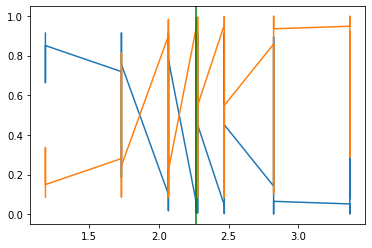

In [26]:
plt.plot(temps, all_values_prob_0)
plt.plot(temps, all_values_prob_1)
plt.axvline(ising_tc, color='g')

Em um primeiro momento é possível observar que o grau de 'confusão' da rede aumenta no intervalo entre 2.0 graus e 2.5 graus, e sabemos que a temperatura de transição de fase encontra-se nesse intervalo.

Para uma melhor visualização, vamos tirar o resultado médio para cada temperatura

In [27]:
def melhor_viz(prob_0, prob_1):
    mean_prob_0 = list()
    mean_prob_1 = list()

    for temp in prob_0.keys():
        tmp_prob_0 = sum(prob_0[temp]) / len(prob_0[temp])
        tmp_prob_1 = sum(prob_1[temp]) / len(prob_1[temp])

        mean_prob_0.append(tmp_prob_0)
        mean_prob_1.append(tmp_prob_1)

    plt.plot(prob_0.keys(), mean_prob_0)
    plt.plot(prob_0.keys(), mean_prob_1)
    plt.axvline(ising_tc, color='g')

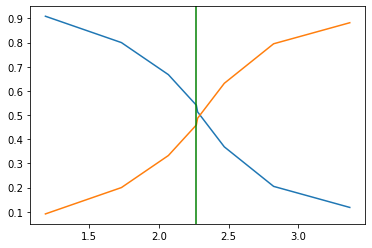

In [28]:
melhor_viz(prob_0, prob_1)

Assim percebemos que o 'ponto de confusão' máximo da rede encontra-se incrivelmente perto da temperatura de transição de fase.

### Utilizando uma rede um pouco mais complexa

In [29]:
more_cpx_model = keras.Sequential([
    layers.Dense(4, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(4, activation='relu'),    
    layers.Dense(1, activation='sigmoid'),
])
more_cpx_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['binary_accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

more_cpx_model_history = more_cpx_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)


In [30]:
more_cpx_model_evaluate = more_cpx_model.evaluate(x_test, y_test)

100/100 [==============================] - 0s 879us/step - loss: 0.5036 - binary_accuracy: 0.7581


In [31]:
print(f"Acurácia no conjunto de teste: {more_cpx_model_evaluate[1]}")

Acurácia no conjunto de teste: 0.7581250071525574


In [32]:
m_prob_0, m_prob_1 = simple_net_calc_prob(teste, more_cpx_model, temps)

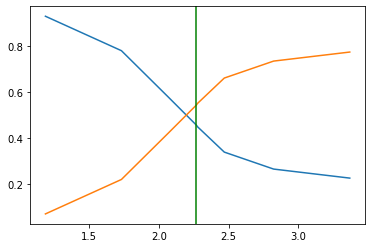

In [33]:
melhor_viz(m_prob_0, m_prob_1)

### Redes mais complexas

#### Le Net 5

In [34]:
x_train = x_train.reshape(-1, 8, 8, 1)
x_test = x_test.reshape(-1, 8, 8, 1)

le_net_model = keras.models.Sequential([
    keras.layers.Input(shape=(8, 8, 1)),
    keras.layers.Conv2D(6, kernel_size=(3, 3), activation='tanh', padding='valid'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='tanh', padding='valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(84, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
])

le_net_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

history_le_net_model = le_net_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
evaluation_le_net_model = le_net_model.evaluate(x_test, y_test)

Epoch 1/10
360/360 [==============================] - 2s 2ms/step - loss: 0.4786 - binary_accuracy: 0.7716 - val_loss: 0.1696 - val_binary_accuracy: 0.9914
Epoch 2/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4594 - binary_accuracy: 0.7833 - val_loss: 0.1257 - val_binary_accuracy: 0.9945
Epoch 3/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4575 - binary_accuracy: 0.7863 - val_loss: 0.1430 - val_binary_accuracy: 0.9945
Epoch 4/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4538 - binary_accuracy: 0.7869 - val_loss: 0.1068 - val_binary_accuracy: 0.9937
Epoch 5/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4524 - binary_accuracy: 0.7891 - val_loss: 0.1545 - val_binary_accuracy: 0.9922
Epoch 6/10
360/360 [==============================] - 1s 2ms/step - loss: 0.4536 - binary_accuracy: 0.7891 - val_loss: 0.1538 - val_binary_accuracy: 0.9930
Epoch 7/10
360/360 [==============================] - 1s 2ms/ste

In [35]:
print(f"Acurácia no conjunto de teste: {evaluation_le_net_model[1]}")

Acurácia no conjunto de teste: 0.8018749952316284


In [36]:
def le_net_calc_prob(teste, model):
    prob_0 = dict()
    prob_1 = dict()
    
    for temp in teste.keys():
        prob_0[temp] = list()
        prob_1[temp] = list()
        
        for conf in teste[temp]:
            element = conf[0].reshape(-1, 8, 8, 1)
            
            prob = model.predict(element, verbose=0)
            
            elemen_prob_1 = prob[0][0]
            elemen_prob_0 = 1 - elemen_prob_1
            
            prob_0[temp].append(elemen_prob_0)
            prob_1[temp].append(elemen_prob_1)
    
    return prob_0, prob_1
            

In [37]:
le_net_prob_0, le_net_prob_1 = le_net_calc_prob(teste, le_net_model)

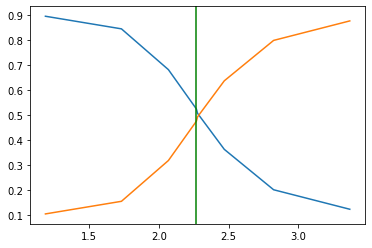

In [38]:
def le_net_melhor_viz():
    mean_prob_0 = list()
    mean_prob_1 = list()

    for temp in le_net_prob_0.keys():
        tmp_prob_0 = sum(le_net_prob_0[temp]) / len(le_net_prob_0[temp])
        tmp_prob_1 = sum(le_net_prob_1[temp]) / len(le_net_prob_1[temp])

        mean_prob_0.append(tmp_prob_0)
        mean_prob_1.append(tmp_prob_1)

    plt.plot(prob_0.keys(), mean_prob_0)
    plt.plot(prob_0.keys(), mean_prob_1)
    plt.axvline(ising_tc, color='g')

le_net_melhor_viz()

#### AlexNet

In [39]:
alex_net_model = keras.models.Sequential([
    keras.layers.Input(shape=(8, 8, 1)),
    keras.layers.Conv2D(96, kernel_size=(3, 3), strides=(2, 2), activation='relu'),
    keras.layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
    keras.layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    keras.layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
    keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
# Compile the model
alex_net_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])


In [40]:
history_alex_net = alex_net_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
evaluation_alex_net = alex_net_model.evaluate(x_test, y_test)

Epoch 1/10
360/360 [==============================] - 142s 392ms/step - loss: 0.5174 - binary_accuracy: 0.7510 - val_loss: 0.1151 - val_binary_accuracy: 0.9844
Epoch 2/10
360/360 [==============================] - 134s 373ms/step - loss: 0.4683 - binary_accuracy: 0.7807 - val_loss: 0.2355 - val_binary_accuracy: 0.9945
Epoch 3/10
360/360 [==============================] - 134s 373ms/step - loss: 0.4665 - binary_accuracy: 0.7786 - val_loss: 0.2450 - val_binary_accuracy: 0.9828
Epoch 4/10
360/360 [==============================] - 138s 383ms/step - loss: 0.4593 - binary_accuracy: 0.7841 - val_loss: 0.1143 - val_binary_accuracy: 0.9953
Epoch 5/10
360/360 [==============================] - 140s 390ms/step - loss: 0.4442 - binary_accuracy: 0.7915 - val_loss: 0.1161 - val_binary_accuracy: 0.9844
Epoch 6/10
360/360 [==============================] - 149s 414ms/step - loss: 0.4177 - binary_accuracy: 0.8025 - val_loss: 0.1078 - val_binary_accuracy: 0.9711
Epoch 7/10
360/360 [====================

In [41]:
print(f"Test Accuracy: {evaluation_alex_net[1]}")

Test Accuracy: 0.7712500095367432


In [42]:
def alex_net_calc_prob(teste, model):
    prob_0 = dict()
    prob_1 = dict()
    
    for temp in teste.keys():
        prob_0[temp] = list()
        prob_1[temp] = list()
        
        for conf in teste[temp]:
            element = conf[0].reshape(-1, 8, 8, 1)
            
            prob = model.predict(element, verbose=0)
            
            elemen_prob_1 = prob[0][0]
            elemen_prob_0 = 1 - elemen_prob_1
            
            prob_0[temp].append(elemen_prob_0)
            prob_1[temp].append(elemen_prob_1)
    
    return prob_0, prob_1

alex_net_prob_0, alex_net_prob_1 = alex_net_calc_prob(teste, alex_net_model)

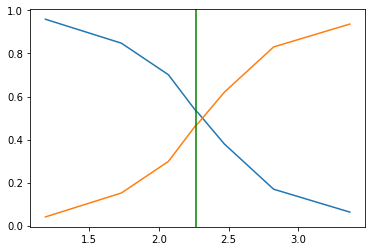

In [43]:
def alex_net_melhor_viz():
    mean_prob_0 = list()
    mean_prob_1 = list()

    for temp in le_net_prob_0.keys():
        tmp_prob_0 = sum(alex_net_prob_0[temp]) / len(alex_net_prob_0[temp])
        tmp_prob_1 = sum(alex_net_prob_1[temp]) / len(alex_net_prob_1[temp])

        mean_prob_0.append(tmp_prob_0)
        mean_prob_1.append(tmp_prob_1)

    plt.plot(prob_0.keys(), mean_prob_0)
    plt.plot(prob_0.keys(), mean_prob_1)
    plt.axvline(ising_tc, color='g')

alex_net_melhor_viz()

#### Vgg net 

Vgg net não roda no sistema utilizado. Utilizaremos o colab no futuro para tentar rodar

In [44]:
"""
vgg_net_model = keras.models.Sequential([
keras.layers.Input(shape=(8, 8, 1)),
keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
#layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
#layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
#layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
#layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
#layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
keras.layers.Flatten(),
keras.layers.Dense(4096, activation='relu'),
keras.layers.Dropout(0.5),
keras.layers.Dense(4096, activation='relu'),
keras.layers.Dropout(0.5),
keras.layers.Dense(1, activation='sigmoid')
])
"""

"\nvgg_net_model = keras.models.Sequential([\nkeras.layers.Input(shape=(8, 8, 1)),\nkeras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),\nkeras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),\n#layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),\nkeras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),\nkeras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),\n#layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),\nkeras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),\nkeras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),\nkeras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),\n#layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),\nkeras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),\nkeras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),\nkeras.lay

In [45]:
#vgg_net_model.compile(optimizer='adam', 
#                      loss='binary_crossentropy',
#                      metrics=['binary_accuracy'])
#history_vgg_net = vgg_net_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1)
#evaluation_vgg_net = vgg_net_model.evaluate(x_test, y_test)

**Algumas conclusões**

- Arquiteturas básicas já são capazes de reconhecer as fases do sistema, especialmente as fases em temperaturas mais extremas.

- Uma rede em que o ponto máximo de confusão coincida com a solução de Onsager não necessariamente é uma rede que teve um melhor desempenho, vimos isso pois uma rede mais básica coincidiu melhor com a temperatura de transição de fase do que redes mais complexas, mesmo a rede mais básica tendo um desempenho pior na avaliação no conjunto de testes. Ainda sim a capaciadade de reconhecimento de padrões em um sistema complexo é notável.

In [46]:
model.save('model.keras')
more_cpx_model.save('more_cpx_model.keras')
le_net_model.save('le_net_model.keras')
alex_net_model.save('alex_net_model.keras')

In [47]:
# Para carregar os modelos e realizar testes sem ter que treinar novamente
# model          = keras.models.load_model('model.keras')
# more_cpx_model = keras.models.load_model('more_cpx_model.keras')
# le_net_model   = keras.models.load_model('le_net_model.keras')
# alex_net_model = keras.models.load_model('alex_net_model.keras')